In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pprint
import requests
import json
from bs4 import BeautifulSoup
import plotly.express as px
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import datetime as dt
from scipy import sparse
import plotly.graph_objects as go

In [3]:
file = './data/loneliness/England/msoa_loneliness.shp'
msoa_map = gpd.read_file(file)
msoa_map.head()

,objectid,msoa11cd,msoa11nm,msoa11nmw,st_areasha,st_lengths,loneills_2,loneills_1,geometry
0,1,E02000001,City of London 001,City of London 001,2.983633e+06,8017.914674,0.610642,#f5f5f5,"POLYGON ((532419.592 181998.305, 532746.814 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.091907e+06,7086.028359,-0.155306,#f5f5f5,"POLYGON ((548452.001 189024.718, 548235.426 18..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.122216e+06,7405.118745,0.326728,#f5f5f5,"POLYGON ((548954.500 189063.203, 548874.188 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.569470e+06,7148.814421,0.324374,#f5f5f5,"POLYGON ((551943.813 186027.672, 551670.812 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.111109e+06,5491.227647,0.334801,#f5f5f5,"POLYGON ((549145.624 187383.875, 549128.657 18..."


In [4]:
msoa_map['loneills_1'] = msoa_map['loneills_1'].replace(['nan'], '#ffffff')
msoa_map['loneills_2'] = msoa_map['loneills_2'].astype(float)

<AxesSubplot:>

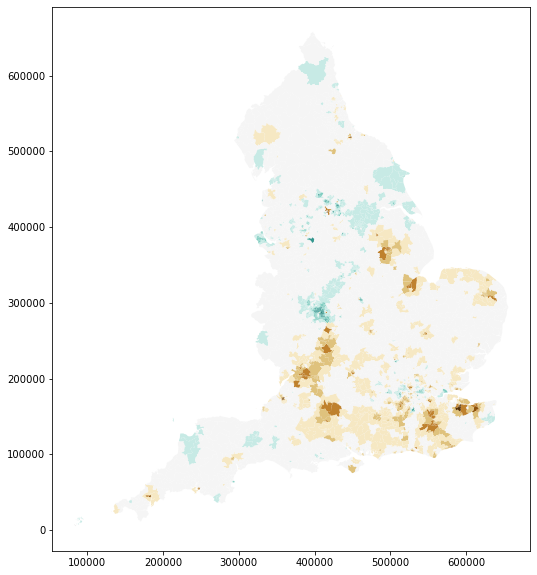

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_map.plot(ax=ax,color=[c for c in msoa_map['loneills_1']], legend=True)

<AxesSubplot:>

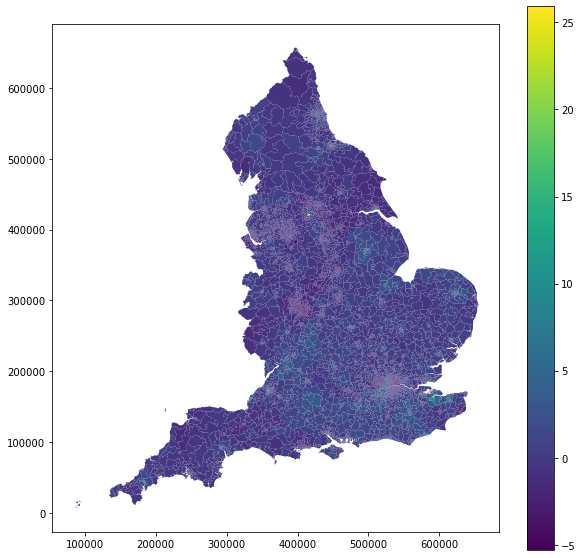

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_map.plot(ax=ax,column='loneills_2', legend=True)

In [5]:
regions = msoa_map['msoa11nm']
new_regions = []
for region in regions:
    new_regions.append(region[:-4])
new_regions = pd.Series(new_regions)

### Rainfall

In [6]:
url = 'https://www.freeflush.co.uk/blogs/freeflush-rainwater-harvesting-blog/30077441-which-is-the-rainiest-city-in-the-uk'
req = requests.get(url)
source = req.text
soup = BeautifulSoup(source, 'html.parser')

In [7]:
table_df = pd.DataFrame(columns=['City', 'Rainfall'])
table = soup.find('table', attrs={
    'class': 'tablesorter'
})
table_body = table.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    columns = row.find_all('td')
    
    if(columns != []):
        city = columns[0].text.strip()
        rainfall = columns[1].text.strip()
        
        table_df = table_df.append({'City':city, 'Rainfall':rainfall}, ignore_index=True)
    
table_df

,City,Rainfall
0,Glasgow,1124
1,St David,1138
2,Cardiff,1152
3,Newry,1019
4,Bangor,1100
...,...,...
58,Chelmsford,592
59,Derry,571
60,Ely,574
61,Cambridge,568


Reafing England shape file

In [12]:
england_shape = './data/england_cities/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.shp'
england_cities = gpd.read_file(england_shape)
england_cities = england_cities.rename(columns={'TCITY15NM' :'City'})
england_cities.head()

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,J01000001,Barnsley,436375,407875,-1.452250,53.56625,2.568247e+07,115099.860000,"POLYGON ((432250.004 411199.994, 432300.002 41..."
1,2,J01000002,Basildon,572525,189350,0.488409,51.57661,2.551499e+07,119299.838000,"MULTIPOLYGON (((567100.007 191450.007, 567100...."
2,3,J01000003,Basingstoke,463725,152600,-1.087930,51.26899,2.918502e+07,93900.388003,"POLYGON ((466600.000 155200.004, 466550.002 15..."
3,4,J01000004,Bath,374800,164325,-2.363450,51.37741,2.423750e+07,92099.940000,"MULTIPOLYGON (((373799.999 167549.999, 373750...."
4,5,J01000005,Bedford,505925,250450,-0.453520,52.14220,2.016749e+07,71300.186000,"MULTIPOLYGON (((505300.000 247500.003, 505250...."


<AxesSubplot:>

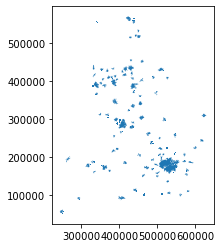

In [13]:
england_cities.plot()

In [14]:
england_file = './data/shape_england/RGN_DEC_2021_EN_BFC.shp'
england_map = gpd.read_file(england_file)

<AxesSubplot:>

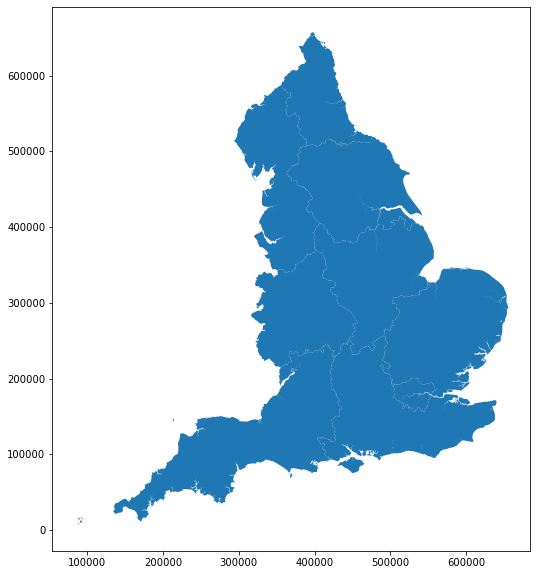

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

england_map.plot(ax=ax)

In [16]:
data = pd.merge(england_cities, table_df, on='City')
data.head(10)

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,Rainfall
0,4,J01000004,Bath,374800,164325,-2.363450,51.37741,2.423750e+07,92099.940000,"MULTIPOLYGON (((373799.999 167549.999, 373750....",814
1,7,J01000007,Birmingham,408850,286925,-1.871110,52.48019,2.291349e+08,271100.218100,"MULTIPOLYGON (((407750.003 276999.999, 407750....",805
2,13,J01000013,Bradford,415525,431875,-1.765870,53.78298,7.000252e+07,188999.530808,"MULTIPOLYGON (((414950.003 426099.999, 414899....",1024
3,15,J01000015,Bristol,362050,173400,-2.547600,51.45829,1.124600e+08,232400.114004,"MULTIPOLYGON (((354150.007 177549.996, 354150....",802
4,19,J01000019,Cambridge,546350,258525,0.140303,52.20553,3.762498e+07,126299.986000,"MULTIPOLYGON (((542999.998 260349.995, 543049....",568
5,20,J01000020,Cardiff,316675,180875,-3.202350,51.52062,7.138014e+07,204900.196010,"MULTIPOLYGON (((317249.986 177150.001, 317199....",1152
6,23,J01000023,Chelmsford,571625,207025,0.484100,51.73566,2.570749e+07,91000.026000,"MULTIPOLYGON (((573400.000 204799.996, 573400....",592
7,25,J01000025,Chester,340350,367350,-2.894400,53.19988,2.361748e+07,82900.062000,"MULTIPOLYGON (((339900.002 367699.996, 339950....",726
8,28,J01000028,Coventry,432700,279725,-1.520650,52.41456,7.357742e+07,238100.008000,"MULTIPOLYGON (((436249.997 283800.002, 436249....",700
9,31,J01000031,Derby,434575,334975,-1.487310,52.91111,5.869997e+07,169700.108000,"MULTIPOLYGON (((430250.000 333800.000, 430250....",709


In [17]:
data.tail()

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,Rainfall
32,96,J01000096,Sunderland,438625,554950,-1.39942,54.88781,3.913749e+07,135299.846000,"MULTIPOLYGON (((440949.986 555499.999, 440899....",597
33,98,J01000098,Swansea,264875,194825,-3.95394,51.63595,4.907997e+07,190900.018000,"MULTIPOLYGON (((266700.003 195300.005, 266700....",999
34,101,J01000101,Wakefield,432575,421550,-1.50820,53.68940,2.926752e+07,122899.966000,"MULTIPOLYGON (((431149.997 416999.994, 431200....",603
35,110,J01000110,Worcester,386575,255800,-2.19784,52.20027,2.423248e+07,89800.048000,"MULTIPOLYGON (((384900.003 254499.999, 384900....",606
36,112,J01000112,York,460225,452150,-1.08357,53.96195,3.369751e+07,114599.972002,"POLYGON ((458849.998 452949.994, 458849.998 45...",626


In [18]:
data['Rainfall'].isna().sum()
data['Rainfall'] = data['Rainfall'].astype(float)

<AxesSubplot:>

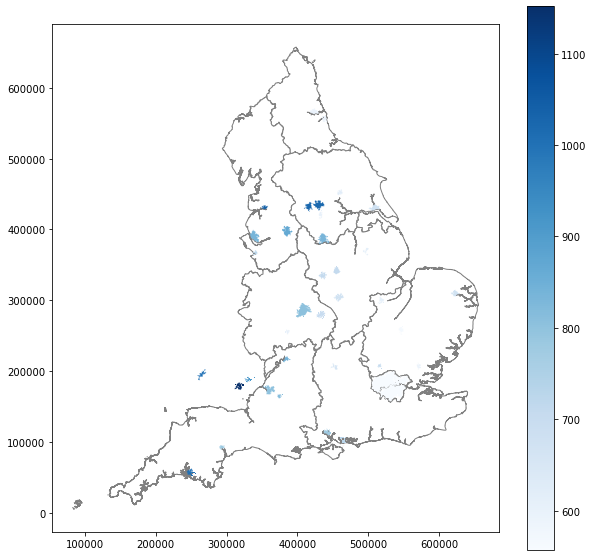

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
england_map.plot(color='white', edgecolor="grey", ax=ax)
data.plot(column='Rainfall', ax=ax, cmap='Blues',legend=True)

In [20]:
new_regions = pd.concat([new_regions,msoa_map['loneills_2']],axis=1)
new_regions = new_regions.rename(columns={0 :'City'})
new_regions

,City,loneills_2
0,City of London,0.610642
1,Barking and Dagenham,-0.155306
2,Barking and Dagenham,0.326728
3,Barking and Dagenham,0.324374
4,Barking and Dagenham,0.334801
...,...,...
6786,Greenwich,0.800393
6787,Greenwich,0.457012
6788,Liverpool,0.187870
6789,Liverpool,-0.659809


In [21]:
rain_loneliness = pd.merge(new_regions, table_df, on='City')
rain_loneliness.tail(50)

,City,loneills_2,Rainfall
1151,Norwich,1.616667,674
1152,Norwich,1.575318,674
1153,Norwich,1.234677,674
1154,Norwich,1.907026,674
1155,Norwich,2.578225,674
1156,Norwich,2.706488,674
1157,Oxford,2.372186,660
1158,Oxford,2.172818,660
1159,Oxford,2.637424,660
1160,Oxford,2.054711,660


In [22]:
print (rain_loneliness.dtypes)

City           object
loneills_2    float64
Rainfall       object
dtype: object


In [23]:
rain_loneliness['Rainfall'] = rain_loneliness['Rainfall'].astype(float)
print (rain_loneliness.dtypes)

City           object
loneills_2    float64
Rainfall      float64
dtype: object


In [24]:
rain_loneliness=rain_loneliness.groupby('City').mean()
rain_loneliness.corr()

,loneills_2,Rainfall
loneills_2,1.000000,-0.325579
Rainfall,-0.325579,1.000000


In [25]:
rain_loneliness.columns

Index(['loneills_2', 'Rainfall'], dtype='object')

In [26]:
rain_loneliness['City'] = rain_loneliness.index
rain_loneliness.columns

Index(['loneills_2', 'Rainfall', 'City'], dtype='object')

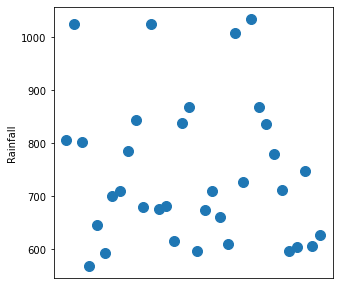

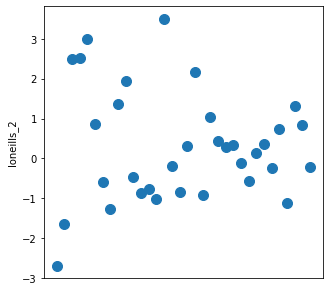

In [27]:
fig1, ax1 = plt.subplots(figsize=(5,5))
fig2, ax2 = plt.subplots(figsize=(5,5))
ax1.axes.xaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
rain_loneliness.plot.scatter(x = 'City', y = 'Rainfall', s = 100, ax=ax1);
rain_loneliness.plot.scatter(x = 'City', y = 'loneills_2', s = 100, ax=ax2);

### Temperature

Reading minimum temperature data for uk (dataset from met office)

In [77]:
fn = 'data/metoffice/tasmin_hadukgrid_uk_1km_ann_201801-201812.nc'
ds = nc.Dataset(fn)

In [78]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    comment: annual resolution gridded climate observations
    creation_date: 2021-07-12T19:50:50
    frequency: ann
    institution: Met Office
    references: doi: 10.1002/joc.1161
    short_name: annual_mintemp
    source: HadUK-Grid_v1.0.3.0
    title: Gridded surface climate observations data for the UK
    version: v20210712
    Conventions: CF-1.7
    dimensions(sizes): time(1), projection_y_coordinate(1450), projection_x_coordinate(900), bnds(2)
    variables(dimensions): float64 tasmin(time, projection_y_coordinate, projection_x_coordinate), int32 transverse_mercator(), float64 time(time), float64 time_bnds(time, bnds), float64 projection_y_coordinate(projection_y_coordinate), float64 projection_y_coordinate_bnds(projection_y_coordinate, bnds), float64 projection_x_coordinate(projection_x_coordinate), float64 projection_x_coordinate_bnds(projection_x_coordinate, bnds), float64 latitude(proje

In [79]:
ds.__dict__

{'comment': 'annual resolution gridded climate observations',
 'creation_date': '2021-07-12T19:50:50',
 'frequency': 'ann',
 'institution': 'Met Office',
 'references': 'doi: 10.1002/joc.1161',
 'short_name': 'annual_mintemp',
 'source': 'HadUK-Grid_v1.0.3.0',
 'title': 'Gridded surface climate observations data for the UK',
 'version': 'v20210712',
 'Conventions': 'CF-1.7'}

In [80]:
ds.variables

{'tasmin': <class 'netCDF4._netCDF4.Variable'>
 float64 tasmin(time, projection_y_coordinate, projection_x_coordinate)
     _FillValue: 1e+20
     standard_name: air_temperature
     long_name: Minimum air temperature
     units: degC
     description: Minimum air temperature
     label_units: C
     level: 1.5m
     plot_label: Minimum air temperature at 1.5m (C)
     cell_methods: time: minimum within days time: mean over days time: mean
     grid_mapping: transverse_mercator
     coordinates: latitude longitude
 unlimited dimensions: 
 current shape = (1, 1450, 900)
 filling on,
 'transverse_mercator': <class 'netCDF4._netCDF4.Variable'>
 int32 transverse_mercator()
     grid_mapping_name: transverse_mercator
     longitude_of_prime_meridian: 0.0
     semi_major_axis: 6377563.396
     semi_minor_axis: 6356256.909
     longitude_of_central_meridian: -2.0
     latitude_of_projection_origin: 49.0
     false_easting: 400000.0
     false_northing: -100000.0
     scale_factor_at_central_m

In [81]:
variables = ds.variables.keys()
variables

dict_keys(['tasmin', 'transverse_mercator', 'time', 'time_bnds', 'projection_y_coordinate', 'projection_y_coordinate_bnds', 'projection_x_coordinate', 'projection_x_coordinate_bnds', 'latitude', 'longitude'])

In [82]:
min_temp = ds['tasmin'][:]
min_temp

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=1e+20)

In [83]:
min_temp.mean()

5.711054820191446

In [84]:
min_temp.data

array([[[1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
        [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
        [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
        ...,
        [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
        [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20],
        [1.e+20, 1.e+20, 1.e+20, ..., 1.e+20, 1.e+20, 1.e+20]]])

In [85]:
min_temp_data = min_temp[min_temp.mask == False].data
min_temp_data

array([10.32674306, 10.34782211, 10.44893399, ...,  5.29907023,
        5.69415881,  5.89742092])

In [86]:
ds['tasmin']

<class 'netCDF4._netCDF4.Variable'>
float64 tasmin(time, projection_y_coordinate, projection_x_coordinate)
    _FillValue: 1e+20
    standard_name: air_temperature
    long_name: Minimum air temperature
    units: degC
    description: Minimum air temperature
    label_units: C
    level: 1.5m
    plot_label: Minimum air temperature at 1.5m (C)
    cell_methods: time: minimum within days time: mean over days time: mean
    grid_mapping: transverse_mercator
    coordinates: latitude longitude
unlimited dimensions: 
current shape = (1, 1450, 900)
filling on

In [89]:
time = ds.variables['time'][:]
lats = ds.variables['latitude'][:]
lons = ds.variables['longitude'][:]
min_temp_units = ds.variables['tasmin'].units

In [107]:
m = Basemap(llcrnrlon=-7.5600,llcrnrlat=49.7600,
            urcrnrlon=2.7800,urcrnrlat=60.840,
            resolution='i',
            projection='tmerc',
            lon_0=-4.36,lat_0=54.7,
            epsg=27700)

In [108]:
x, y = m(lons, lats)

<ipython-input-116-0aef5af3f638>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = m.pcolor(x,y,np.squeeze(min_temp))


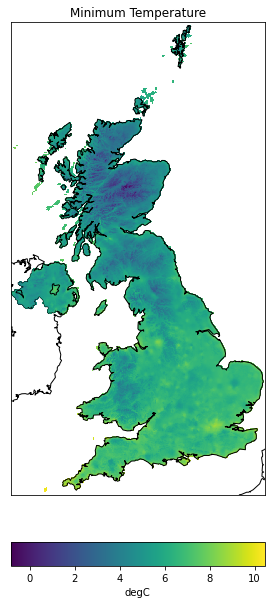

In [116]:
# fig, ax = plt.subplots(figsize=(10,10))

# cs = m.pcolor(x,y,np.squeeze(min_temp))
# m.drawmapboundary(fill_color='#46bcec')
# m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
# m.drawcoastlines()
# m.drawrivers()
# cbar = m.colorbar(cs, location='bottom', pad="10%")
# cbar.set_label(min_temp_units)
# plt.title('Minimum Temperature')
# plt.show()

# Plot Data
fig, ax = plt.subplots(figsize=(10,10))
cs = m.pcolor(x,y,np.squeeze(min_temp))

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(min_temp_units)

# Add Title
plt.title('Minimum Temperature')

plt.show()

In [64]:
time

masked_array(data=[1915332.],
             mask=False,
       fill_value=1e+20)

In [130]:
min_temp.compressed()

array([10.32674306, 10.34782211, 10.44893399, ...,  5.29907023,
        5.69415881,  5.89742092])

In [131]:
import xarray as xr

ds = xr.open_dataset('data/metoffice/tasmin_hadukgrid_uk_1km_ann_201801-201812.nc')
df = ds.to_dataframe()

### Rainfall from worldweatheronline

https://www.worldweatheronline.com/united-kingdom-weather.aspx

In [2]:
rainfall = pd.read_excel('./data/weather_by_region/rainfall.xls')
rainfall = rainfall[['New LA Code', 'Average Rainfall (June, mm)']]
rainfall.head()

,New LA Code,"Average Rainfall (June, mm)"
0,E09000001,101.4
1,E09000007,72.4
2,E09000011,83.1
3,E09000012,101.4
4,E09000013,93.0


In [3]:
master_df = pd.read_csv('../master_df.csv')
print(master_df.shape)
master_df.head()

(337, 29)


,Unnamed: 0,LA code,Ofsted Avg,lonely_avg,KS2 metrics PCA,GDHI income index,LA name,LA flow rate,All Ages,meds,...,No Offer %S,Offer in diff LA code %S,FSM Eligible %,<2 A levels,< AAB,perm_excl_rate,Unsuccessful Appeals,% of ppl not doing degrees,progression_rate,total_pop
0,0,E06000001,3.000000,-0.542761,-22376.054139,NaN,Hartlepool,0.006371,7819.666667,40.914654,...,0.000000,0.520833,25.797120,29.545,89.831,7.240653,75.0,53.4,0.389333,5480.0
1,1,E06000002,2.955556,1.316155,-16308.990169,NaN,Middlesbrough,0.009093,7472.833333,38.022965,...,0.057307,13.638936,24.189824,36.743,90.881,17.357524,78.3,46.1,0.413947,7890.0
2,2,E06000003,2.791667,0.649266,-18159.719122,76.2,Redcar and Cleveland,0.006576,7222.526316,44.315926,...,0.135227,1.928191,17.971133,23.263,86.907,26.902558,58.2,23.0,0.374421,7550.0
3,3,E06000004,3.085714,0.635474,-11390.336475,79.3,Stockton-on-Tees,0.006511,8225.791667,41.914379,...,0.500000,2.574526,16.438313,22.014,81.560,12.734798,71.0,22.7,0.427333,10385.0
4,4,E06000005,2.894737,0.967079,-22128.626436,82.8,Darlington,0.007179,7160.133333,42.795048,...,0.000000,1.426025,16.558996,23.524,82.458,6.176271,71.2,35.8,0.390533,5635.0


In [4]:
la_codes = master_df['LA code']
print(len(la_codes.values))

337


In [5]:
rainfall = rainfall[rainfall['New LA Code'].isin(la_codes.values)]
rainfall.shape

(149, 2)

In [6]:
rainfall = rainfall.rename(columns={"New LA Code": "LA code"})

In [7]:
rainfall.head()

,LA code,"Average Rainfall (June, mm)"
0,E09000001,101.4
1,E09000007,72.4
2,E09000011,83.1
3,E09000012,101.4
4,E09000013,93.0


In [8]:
master_df = master_df.merge(rainfall[['LA code', 'Average Rainfall (June, mm)']], how='inner', left_on='LA code', right_on='LA code')
print(master_df.shape)
master_df.head()

(149, 30)


,Unnamed: 0,LA code,Ofsted Avg,lonely_avg,KS2 metrics PCA,GDHI income index,LA name,LA flow rate,All Ages,meds,...,Offer in diff LA code %S,FSM Eligible %,<2 A levels,< AAB,perm_excl_rate,Unsuccessful Appeals,% of ppl not doing degrees,progression_rate,total_pop,"Average Rainfall (June, mm)"
0,0,E06000001,3.000000,-0.542761,-22376.054139,NaN,Hartlepool,0.006371,7819.666667,40.914654,...,0.520833,25.797120,29.545,89.831,7.240653,75.0,53.4,0.389333,5480.0,88.6
1,1,E06000002,2.955556,1.316155,-16308.990169,NaN,Middlesbrough,0.009093,7472.833333,38.022965,...,13.638936,24.189824,36.743,90.881,17.357524,78.3,46.1,0.413947,7890.0,94.0
2,2,E06000003,2.791667,0.649266,-18159.719122,76.2,Redcar and Cleveland,0.006576,7222.526316,44.315926,...,1.928191,17.971133,23.263,86.907,26.902558,58.2,23.0,0.374421,7550.0,89.0
3,3,E06000004,3.085714,0.635474,-11390.336475,79.3,Stockton-on-Tees,0.006511,8225.791667,41.914379,...,2.574526,16.438313,22.014,81.560,12.734798,71.0,22.7,0.427333,10385.0,66.6
4,4,E06000005,2.894737,0.967079,-22128.626436,82.8,Darlington,0.007179,7160.133333,42.795048,...,1.426025,16.558996,23.524,82.458,6.176271,71.2,35.8,0.390533,5635.0,71.2


In [9]:
rainfall.to_csv('./data/rainfall.csv')

In [10]:
la_map = pd.read_csv('./data/la_england/Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.csv')
print(la_map.shape)
la_map.head()

(380, 10)


,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape
0,1,E06000001,Hartlepool,,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561
2,3,E06000003,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,2.448203e+08,97993.391012
3,4,E06000004,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,2.049622e+08,119581.595543
4,5,E06000005,Darlington,,428029,515649,-1.56835,54.535351,1.974757e+08,107206.401694


In [11]:
la_map = la_map[la_map['lad17cd'].isin(la_codes.values)]
print(la_map.shape)
la_map.head()

(301, 10)


,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape
0,1,E06000001,Hartlepool,,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561
2,3,E06000003,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,2.448203e+08,97993.391012
3,4,E06000004,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,2.049622e+08,119581.595543
4,5,E06000005,Darlington,,428029,515649,-1.56835,54.535351,1.974757e+08,107206.401694


In [12]:
rainfall_map = la_map.merge(rainfall, how='inner', left_on='lad17cd', right_on='LA code').drop('LA code', 1)
rainfall_map.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,"Average Rainfall (June, mm)"
0,1,E06000001,Hartlepool,,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,88.6
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,94.0
2,3,E06000003,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,2.448203e+08,97993.391012,89.0
3,4,E06000004,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,2.049622e+08,119581.595543,66.6
4,5,E06000005,Darlington,,428029,515649,-1.56835,54.535351,1.974757e+08,107206.401694,71.2


In [13]:
la_map = gpd.read_file('./data/la_england/LAD_MAY_2021_UK_BFE_V2.shp')
la_map.head()

,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry
0,1,E06000001,Hartlepool,447160,531474,-1.27018,54.676140,66110.011028,9.835107e+07,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,2,E06000002,Middlesbrough,451141,516887,-1.21099,54.544670,41055.789790,5.455359e+07,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,3,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.567520,105292.103526,2.537854e+08,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,4,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.556911,108085.190140,2.097308e+08,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,5,E06000005,Darlington,428029,515648,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [14]:
rainfall_map = la_map.merge(rainfall, how='inner', left_on='LAD21CD', right_on='LA code').drop('LA code', 1)
print(rainfall_map.shape)
rainfall_map.head()

(121, 11)


,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,"Average Rainfall (June, mm)"
0,1,E06000001,Hartlepool,447160,531474,-1.27018,54.676140,66110.011028,9.835107e+07,"POLYGON ((447213.900 537036.104, 447228.798 53...",88.6
1,2,E06000002,Middlesbrough,451141,516887,-1.21099,54.544670,41055.789790,5.455359e+07,"POLYGON ((448489.897 522071.798, 448592.597 52...",94.0
2,3,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.567520,105292.103526,2.537854e+08,"POLYGON ((455525.931 528406.654, 455724.632 52...",89.0
3,4,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.556911,108085.190140,2.097308e+08,"POLYGON ((444157.002 527956.304, 444165.898 52...",66.6
4,5,E06000005,Darlington,428029,515648,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((423496.602 524724.299, 423497.204 52...",71.2


In [15]:
la_map = la_map[la_map['LAD21CD'].str.startswith('E')]

<AxesSubplot:>

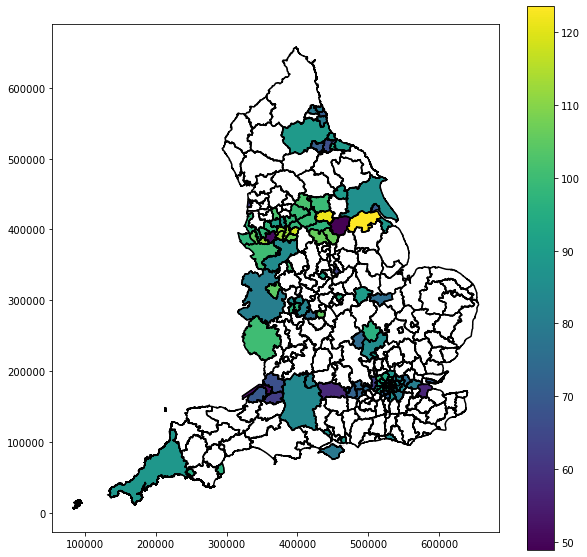

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
la_map.boundary.plot(ax=ax,edgecolor="black");
rainfall_map.plot(ax=ax,column='Average Rainfall (June, mm)', edgecolor="black",legend=True)

In [17]:
master_df[['lonely_avg','Average Rainfall (June, mm)']].corr()

,lonely_avg,"Average Rainfall (June, mm)"
lonely_avg,1.000000,-0.226249
"Average Rainfall (June, mm)",-0.226249,1.000000


### Rainfall ML